In [187]:
import os
import nni
import yaml
import argparse
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from UCTB.dataset import DataSet

from UCTB.dataset import NodeTrafficLoader
from UCTB.model import STMeta
from UCTB.evaluation import metric
from UCTB.preprocess.time_utils import is_work_day_china, is_work_day_america

from UCTB.preprocess.GraphGenerator import GraphGenerator
from UCTB.preprocess import Normalizer, SplitData

In [188]:
inflow_loader = NodeTrafficLoader(dataset="Metro",city="Shanghai_Inflow")

traffic (16416, 287)
test: (1642, 287)
train: (14774, 287)
test: (8362, 287)


In [189]:
outflow_loader = NodeTrafficLoader(dataset="Metro",city="Shanghai_Outflow")

traffic (16416, 287)
test: (1642, 287)
train: (14774, 287)
test: (8362, 287)


In [190]:
inflow_loader.dataset.time_range

['2016-07-01', '2016-09-14']

In [191]:
def showStation(traffic,offset,showdays,stationNum,fitness=5, newfigure=False):
    if newfigure:
        plt.figure(figsize=(20,8))
    offset *= (60//fitness)*24
    offset = int(offset)
    x =traffic[(0+offset):int((60//fitness)*24*showdays+offset),stationNum]
    plt.plot(list(range(len(x))),x)

In [192]:
in_traffic = inflow_loader.traffic_data
out_traffic = outflow_loader.traffic_data

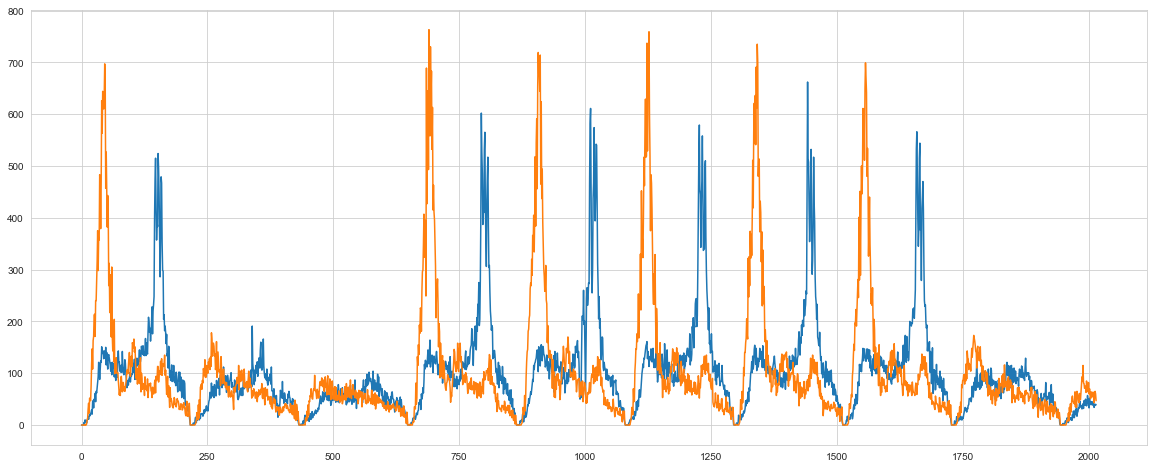

In [193]:
offset = 0
showdays = 7
fitness = 5 # mins
stationNum = 149
plt.figure(figsize=(20,8))
showStation(in_traffic,offset,showdays,stationNum,fitness=fitness)
showStation(out_traffic,offset,showdays,stationNum,fitness=fitness)
# 同一站点的inflow 和outflow展现出明显的pattern

In [194]:
StationInfo = inflow_loader.dataset.data['Node']['StationInfo']

In [195]:
StationInfo

[['0', '0101-0501', 31.111193, 121.385379, '1号线莘庄'],
 ['1', '0102', 31.120899, 121.39302, '1号线外环路'],
 ['2', '0103', 31.130986, 121.402943, '1号线莲花路'],
 ['3', '0104', 31.142217, 121.414107, '1号线锦江乐园'],
 ['4', '0105-0301', 31.154579, 121.430041, '1号线上海南站', '3号线上海南站'],
 ['5', '0106-1225', 31.168338, 121.433141, '1号线漕宝路'],
 ['6', '0107-0426E', 31.182813, 121.437423, '1号线上海体育馆', '4号线上海体育馆'],
 ['7', '0108-0917-1114', 31.195338, 121.436837, '1号线徐家汇', '9号线徐家汇'],
 ['8', '0109', 31.204528, 121.446424, '1号线衡山路'],
 ['9', '0110-0720', 31.213524, 121.449141, '1号线常熟路', '7号线常熟路'],
 ['10', '0111-1017-1219', 31.21515, 121.458744, '10号线陕西南路', '1号线陕西南路'],
 ['11', '0112', 31.222745, 121.473306, '1号线黄陂南路'],
 ['12', '0113-0212-0815', 31.23273, 121.47564, '1号线人民广场', '8号线人民广场'],
 ['13', '0114', 31.238373, 121.468151, '1号线新闸路'],
 ['14', '0115-1217-1312', 31.241883, 121.458699, '1号线汉中路'],
 ['15', '0116-0313-0409', 31.249538, 121.458219, '1号线上海火车站', '3号线上海火车站'],
 ['16', '0117', 31.258891, 121.459204, '1号线中山北路'],
 

In [10]:
station_name_ls = []
for x in StationInfo:
    station_name_ls += x[4:]

In [11]:
import re
pattern = "\d+号线"
lines_names = np.unique([re.match(pattern, x).group() for x in station_name_ls])
lines_names.sort()

In [12]:
lines_names

array(['10号线', '11号线', '12号线', '13号线', '16号线', '1号线', '2号线', '3号线', '4号线',
       '5号线', '6号线', '7号线', '8号线', '9号线'], dtype='<U4')

In [13]:
lat_ls = [x[2] for x in StationInfo]
lng_ls = [x[3] for x in StationInfo]

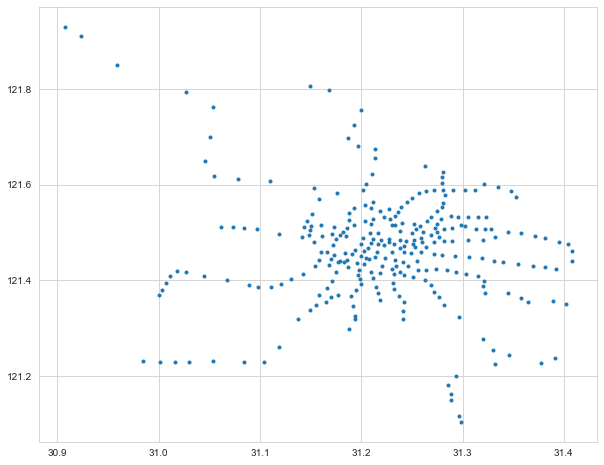

In [14]:
plt.figure(figsize=(10,8))
plt.plot(lat_ls,lng_ls,'.')

In [ ]:
'''
1号地铁时刻表

车站    首班车    常态末班车发车时刻（周日-周四）    延时运营末班车发车时刻（周五-周六）    
往富锦路    往上海站    往莘庄    往富锦路    往上海站    往莘庄    往富锦路    往上海站    往莘庄    
莘庄    05:30    05:30    06:04(到达)    22:32    22:32    23:34(到达)    23:50    23:50    次00:54(到达)    
外环路    05:32    05:32    06:02    22:34    22:34    23:32    23:52    23:52    次00:52    
莲花路    05:34    05:34    06:00    22:36    22:36    23:30    23:54    23:54    次00:50    
锦江乐园    05:37    05:37    05:57    22:39    22:39    23:27    23:57    23:57    次00:47    
上海南站    05:18    04:55    05:54    22:42    22:42    23:24    次00:00    次00:00    次00:44    
漕宝路    05:20    04:57    05:51    22:45    22:45    23:21    次00:03    次00:03    次00:41    
上海体育馆    05:23    05:00    05:49    22:48    22:48    23:19    次00:06    次00:06    次00:39    
徐家汇    05:25    05:02    05:46    22:50    22:50    23:16    次00:08    次00:08    次00:36    
衡山路    05:27    05:04    05:44    22:52    22:52    23:14    次00:10    次00:10    次00:34    
常熟路    05:29    05:06    05:42    22:54    22:54    23:12    次00:12    次00:12    次00:32    
陕西南路    05:31    05:08    05:40    22:56    22:56    23:10    次00:14    次00:14    次00:30    
黄陂南路    05:34    05:11    05:38    22:58    22:58    23:08    次00:16    次00:16    次00:28    
人民广场    05:37    05:14    05:35    23:01    23:01    23:05    次00:19    次00:19    次00:25    
新闸路    05:38    05:15    05:33    23:03    23:03    23:03    次00:21    次00:21    次00:23    
汉中路    05:40    05:17    05:31    23:05    23:05    23:01    次00:23    次00:23    次00:21    
上海火车站    05:43    05:19(到达)    05:30    23:08    23:08    23:00    次00:26    次00:26    次00:20    
中山北路    05:45    --    05:57    23:10    --    22:57    次00:28    --    次00:17    
延长路    05:48    --    05:55    23:13    --    22:55    次00:31    --    次00:15    
上海马戏城    05:50    --    05:53    23:15    --    22:53    次00:33    --    次00:13    
汶水路    05:52    --    05:50    23:17    --    22:50    次00:35    --    次00:10    
彭浦新村    05:55    --    05:47    23:20    --    22:47    次00:38    --    次00:07    
共康路    05:58    --    05:45    23:23    --    22:45    次00:41    --    次00:05    
通河新村    06:00    --    05:42    23:25    --    22:42    次00:43    --    次00:02    
呼兰路    06:03    --    05:40    23:27    --    22:40    次00:45    --    次00:00    
共富新村    06:05    --    05:37    23:30    --    22:37    次00:48    --    23:57    
宝安公路    06:08    --    05:34    23:33    --    22:34    次00:51    --    23:54    
友谊西路    06:10    --    05:32    23:35    --    22:32    次00:53    --    23:52    
富锦路    06:12(到达)    --    05:30    23:37(到达)    --    22:30    次00:55(到达)    --    23:50    

周一　～　周四    
名称    时段    列车间隔    
莘庄～上海火车站    上海火车站～富锦路    
早高峰    7:00～9:00    平均2分30秒    
平峰    9:00～17:00    平均4分    平均6分    
晚高峰    17:00～19:00    平均3分    
其余时段    4分 ～?9分    
周五    
名称    时段    列车间隔    
莘庄～上海火车站    上海火车站～富锦路    
早高峰    7:00～9:00    平均2分30秒    
平峰    9:00～14:30    平均4分    平均6分    
晚高峰    14:30～17:00    平均4分    
17:00～19:00    平均3分    
其余时段    4分～9分    
周六、周日    
名称    时段    列车间隔    
莘庄～上海火车站    上海火车站～富锦路    
高峰时段    9:00～20:00    平均4分    
其余时段    6分～12分    
延时运营列车间隔（周五、周六）    
名称    时段    列车间隔    
莘庄～富锦路    
延时运营    22:30～运营结束    10分～16分    
'''

# generate static graph

In [2]:
import pandas as pd
import dateutil

In [170]:
#line_path = os.path.abspath("/Users/chenliyue/Documents/GitHub/dynamic-graph/line1.xlsx")
line_path = os.path.join(os.getcwd(),"line1.xlsx")

In [177]:
line_data = pd.read_excel(line_path)

In [178]:
line_width = {}
for x in line_data.columns:
    if isinstance(x,int):
        curr_line = x
        count = 1
    else:
        count += 1
    line_width[curr_line] = count
accumulate = 0
for key in line_width.keys():
    tmp = line_width[key]
    line_width[key] = [accumulate,accumulate + tmp]
    accumulate += tmp
line_data.columns = [x for x in range(len(line_data.columns))]

In [179]:
def meanless_transform(time_data):
    try:
        return dateutil.parser.parse(time_data.strftime("%H:%M:%S"))
    except Exception as e:
        time_data = time_data.replace("(到达)","")
        return dateutil.parser.parse(time_data)

In [180]:
def checkCol_ADD(df,row,col):
    return bool(1-pd.isna(df.iloc[row][col])) and bool(1-pd.isna(df.iloc[row+1][col]))

def checkFlag(delta, flag): 
    if delta.days == 0:
        tmp_flag = True
    else:
        tmp_flag = False    
    if flag == tmp_flag:
        return True
    else:
        return False


def trans_every_col(Acol_tmp,line_num):
    # Acol_tmp should be (n,2) and it should look like
    #0 往富锦路 往莘庄
    #1 莘庄 05:30:00
    #2 外环路 05:32:00
    triple = []
    ii = 1
    while(pd.isna(Acol_tmp.iloc[ii][1])):
        ii += 1
    delta = meanless_transform(Acol_tmp.iloc[ii+1][1]) - meanless_transform(Acol_tmp.iloc[ii][1])
    if delta.days == 0:
        increase_flag = True
    else:
        increase_flag = False

    for ind in range(1,Acol_tmp.shape[0]-1):
        if checkCol_ADD(Acol_tmp,ind,0):
            if checkCol_ADD(Acol_tmp,ind,1):
                try:
                    delta = meanless_transform(Acol_tmp.iloc[ind+1][1]) - meanless_transform(Acol_tmp.iloc[ind][1])
                    if checkFlag(delta, increase_flag):
                        if increase_flag:
                            result = meanless_transform(Acol_tmp.iloc[ind+1][1]) - meanless_transform(Acol_tmp.iloc[ind][1])
                        else:
                            result = meanless_transform(Acol_tmp.iloc[ind][1]) - meanless_transform(Acol_tmp.iloc[ind+1][1])
                        
                        temp_info = ["{}号线{}".format(line_num,Acol_tmp.iloc[ind][0]),"{}号线{}".format(line_num,Acol_tmp.iloc[ind+1][0]),str(result.seconds)]
                        triple.append(temp_info)
                        print(" ".join(temp_info))
                except Exception as e:
                    print("************************************************")
                    print(e)
                    print(Acol_tmp.iloc[ind][1],Acol_tmp.iloc[ind+1][1])
                    print("************************************************")
    return triple
        

In [181]:
triple_ls = []
for key in line_width.keys():
    left = line_width[key][0]
    right = line_width[key][1]
    num_cols = right - left
    for ind in range(1, num_cols):
        try:
            Acol_tmp = line_data[[left,left+ind]].copy()
            Acol_tmp.columns = [x for x in range(len(Acol_tmp.columns))]
            triple_ls += trans_every_col(Acol_tmp, key)
        except Exception as e:
            print(e)
            print("key is:" ,key)
            print("range is :",left,left+ind)


1号线莘庄 1号线外环路 120
1号线外环路 1号线莲花路 120
1号线莲花路 1号线锦江乐园 180
1号线上海南站 1号线漕宝路 120
1号线漕宝路 1号线上海体育馆 180
1号线上海体育馆 1号线徐家汇 120
1号线徐家汇 1号线衡山路 120
1号线衡山路 1号线常熟路 120
1号线常熟路 1号线陕西南路 120
1号线陕西南路 1号线黄陂南路 180
1号线黄陂南路 1号线人民广场 180
1号线人民广场 1号线新闸路 60
1号线新闸路 1号线汉中路 120
1号线汉中路 1号线上海火车站 180
1号线上海火车站 1号线中山北路 120
1号线中山北路 1号线延长路 180
1号线延长路 1号线上海马戏城 120
1号线上海马戏城 1号线汶水路 120
1号线汶水路 1号线彭浦新村 180
1号线彭浦新村 1号线共康路 180
1号线共康路 1号线通河新村 120
1号线通河新村 1号线呼兰路 180
1号线呼兰路 1号线共富新村 120
1号线共富新村 1号线宝安公路 180
1号线宝安公路 1号线友谊西路 120
1号线友谊西路 1号线富锦路 120
1号线莘庄 1号线外环路 120
1号线外环路 1号线莲花路 120
1号线莲花路 1号线锦江乐园 180
1号线上海南站 1号线漕宝路 120
1号线漕宝路 1号线上海体育馆 180
1号线上海体育馆 1号线徐家汇 120
1号线徐家汇 1号线衡山路 120
1号线衡山路 1号线常熟路 120
1号线常熟路 1号线陕西南路 120
1号线陕西南路 1号线黄陂南路 180
1号线黄陂南路 1号线人民广场 180
1号线人民广场 1号线新闸路 60
1号线新闸路 1号线汉中路 120
1号线汉中路 1号线上海火车站 120
2号线徐泾东 2号线虹桥火车站 120
2号线虹桥火车站 2号线虹桥2号航站楼 120
2号线虹桥2号航站楼 2号线淞虹路 420
2号线淞虹路 2号线北新泾 180
2号线北新泾 2号线威宁路 120
2号线威宁路 2号线娄山关路 180
2号线娄山关路 2号线中山公园 180
2号线中山公园 2号线江苏路 180
2号线江苏路 2号线静安寺 180
2号线静安寺 2号线南京西路 120
2号线南京西路 2号线人民广场 120
2号线人民广场 2号线南京东路 180
2

10号线五角场 10号线江湾体育场 60
10号线江湾体育场 10号线三门路 120
10号线三门路 10号线殷高东路 120
10号线殷高东路 10号线新江湾城 120
10号线虹桥火车站 10号线虹桥2号航站楼 60
10号线虹桥2号航站楼 10号线虹桥1号航站楼 180
10号线虹桥1号航站楼 10号线上海动物园 180
10号线上海动物园 10号线龙溪路 120
10号线龙溪路 10号线水城路 120
10号线水城路 10号线伊犁路 120
10号线伊犁路 10号线宋园路 120
10号线宋园路 10号线虹桥路 120
10号线虹桥路 10号线交通大学 180
10号线交通大学 10号线上海图书馆 120
10号线上海图书馆 10号线陕西南路 120
10号线陕西南路 10号线新天地 180
10号线新天地 10号线老西门 120
10号线老西门 10号线豫园 180
10号线豫园 10号线南京东路 120
10号线南京东路 10号线天潼路 120
10号线天潼路 10号线四川北路 120
10号线四川北路 10号线海伦路 120
10号线海伦路 10号线邮电新村 120
10号线邮电新村 10号线四平路 120
10号线四平路 10号线同济大学 120
10号线同济大学 10号线国权路 120
10号线国权路 10号线五角场 120
10号线五角场 10号线江湾体育场 60
10号线江湾体育场 10号线三门路 120
10号线三门路 10号线殷高东路 120
10号线殷高东路 10号线新江湾城 120
10号线航中路 10号线紫藤路 180
10号线紫藤路 10号线龙柏新村 120
10号线龙溪路 10号线水城路 120
10号线水城路 10号线伊犁路 180
10号线伊犁路 10号线宋园路 60
10号线宋园路 10号线虹桥路 120
10号线虹桥路 10号线交通大学 180
10号线交通大学 10号线上海图书馆 120
10号线上海图书馆 10号线陕西南路 120
10号线陕西南路 10号线新天地 180
10号线新天地 10号线老西门 120
10号线老西门 10号线豫园 120
10号线豫园 10号线南京东路 120
10号线南京东路 10号线天潼路 180
10号线天潼路 10号线四川北路 120
10号线四川北路 10号线海伦路 120
10号

In [154]:
pd.DataFrame(triple_ls,columns=["start",'end',"duration"]).to_csv("triple.csv",index=False,encoding="")

# transform triple

In [182]:
import pandas as pd
import dateutil

In [206]:
path = os.path.join(os.getcwd(),"triple.csv")
triple_data = pd.read_csv(path)

In [207]:
triple_data.head()

,start,end,duration
0,1号线莘庄,1号线外环路,120
1,1号线外环路,1号线莲花路,120
2,1号线莲花路,1号线锦江乐园,180
3,1号线上海南站,1号线漕宝路,120
4,1号线漕宝路,1号线上海体育馆,180


In [208]:
name2index = {}
for ind,x in enumerate(StationInfo):
    for tmp in x[4:]:
        name2index[tmp] = ind

In [209]:
graph = np.zeros((len(StationInfo),len(StationInfo)))

In [214]:
for i in range(triple_data.shape[0]):
    try:
        tmp = triple_data.iloc[i]
        graph[name2index[tmp['start']]][name2index[tmp['end']]] = int(tmp['duration'])
    except Exception as e:
        print("*******************************")
        print("key is: ", e)
        print("pair is: ",tmp['start'],tmp['end'])
        print("*******************************")
        

*******************************
key is:  '2号线人民广场'
pair is:  2号线南京西路 2号线人民广场
*******************************
*******************************
key is:  '2号线人民广场'
pair is:  2号线人民广场 2号线南京东路
*******************************
*******************************
key is:  '2号线世纪大道'
pair is:  2号线东昌路 2号线世纪大道
*******************************
*******************************
key is:  '2号线世纪大道'
pair is:  2号线世纪大道 2号线上海科技馆
*******************************
*******************************
key is:  '2号线人民广场'
pair is:  2号线南京西路 2号线人民广场
*******************************
*******************************
key is:  '2号线人民广场'
pair is:  2号线人民广场 2号线南京东路
*******************************
*******************************
key is:  '2号线世纪大道'
pair is:  2号线东昌路 2号线世纪大道
*******************************
*******************************
key is:  '2号线世纪大道'
pair is:  2号线世纪大道 2号线上海科技馆
*******************************
*******************************
key is:  '3号线淞滨路'
pair is:  3号线张华浜 3号线淞滨路
*******************************
**********************

*******************************
key is:  '12号线七莘路'
pair is:  12号线七莘路 12号线虹莘路
*******************************
*******************************
key is:  '12号线虹莘路'
pair is:  12号线虹莘路 12号线顾戴路
*******************************
*******************************
key is:  '12号线顾戴路'
pair is:  12号线顾戴路 12号线东兰路
*******************************
*******************************
key is:  '12号线东兰路'
pair is:  12号线东兰路 12号线虹梅路
*******************************
*******************************
key is:  '12号线虹梅路'
pair is:  12号线虹梅路 12号线虹漕路
*******************************
*******************************
key is:  '12号线虹漕路'
pair is:  12号线虹漕路 12号线桂林公园
*******************************
*******************************
key is:  '12号线桂林公园'
pair is:  12号线桂林公园 12号线漕宝路
*******************************
*******************************
key is:  '12号线漕宝路'
pair is:  12号线漕宝路 12号线龙漕路
*******************************
*******************************
key is:  '12号线龙漕路'
pair is:  12号线龙漕路 12号线龙华
*******************************
*****************

In [223]:
original_name = []
for x in StationInfo:
    original_name += x[4:]

In [224]:
original_name

['1号线莘庄',
 '1号线外环路',
 '1号线莲花路',
 '1号线锦江乐园',
 '1号线上海南站',
 '3号线上海南站',
 '1号线漕宝路',
 '1号线上海体育馆',
 '4号线上海体育馆',
 '1号线徐家汇',
 '9号线徐家汇',
 '1号线衡山路',
 '1号线常熟路',
 '7号线常熟路',
 '10号线陕西南路',
 '1号线陕西南路',
 '1号线黄陂南路',
 '1号线人民广场',
 '8号线人民广场',
 '1号线新闸路',
 '1号线汉中路',
 '1号线上海火车站',
 '3号线上海火车站',
 '1号线中山北路',
 '1号线延长路',
 '1号线上海马戏城',
 '1号线汶水路',
 '1号线彭浦新村',
 '1号线共康路',
 '1号线通河新村',
 '1号线呼兰路',
 '1号线共富新村',
 '1号线宝安公路',
 '1号线友谊西路',
 '1号线富锦路',
 '2号线徐泾东',
 '2号线虹桥火车站',
 '2号线虹桥2号航站楼',
 '2号线淞虹路',
 '2号线北新泾',
 '2号线威宁路',
 '2号线娄山关路',
 '2号线中山公园',
 '3号线中山公园',
 '11号线江苏路',
 '2号线江苏路',
 '2号线静安寺',
 '7号线静安寺',
 '2号线南京西路',
 '10号线南京东路',
 '2号线南京东路',
 '2号线陆家嘴',
 '2号线东昌路',
 '4号线世纪大道',
 '2号线上海科技馆',
 '2号线世纪公园',
 '16号线龙阳路',
 '2号线龙阳路',
 '7号线龙阳路',
 '2号线张江高科',
 '2号线金科路',
 '2号线广兰路',
 '2号线唐镇',
 '2号线创新中路',
 '2号线华夏东路',
 '2号线川沙',
 '2号线凌空路',
 '2号线远东大道',
 '2号线海天三路',
 '2号线浦东国际机场',
 '3号线石龙路',
 '3号线龙漕路',
 '3号线漕溪路',
 '3号线宜山路',
 '4号线宜山路',
 '9号线宜山路',
 '10号线虹桥路',
 '3号线虹桥路',
 '3号线延安西路',
 '13号线金沙江路',
 '3号线金沙江路',
 '11号线曹杨路',
 '3号线曹杨路',
 '3号线镇坪路',
 '7号线镇坪路',
 '3号线中潭路',

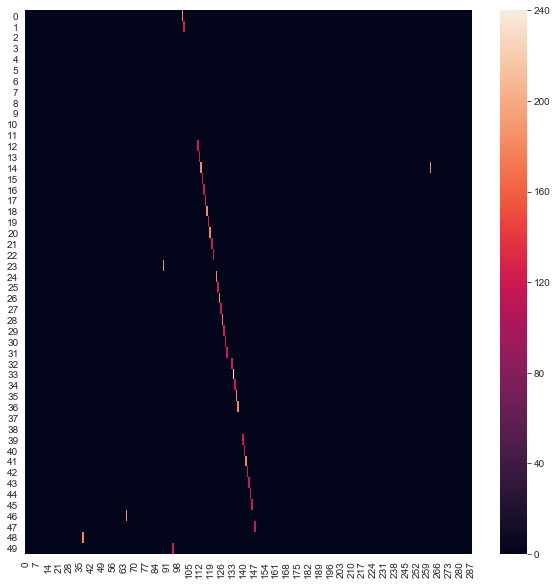

In [221]:
start = 100
end = 150
plt.figure(figsize=(10,10))
show = graph[start:end][:]
show = graph[:][start:end]
sns.heatmap(show,annot=False)

In [215]:
name2index

{'1号线莘庄': 0,
 '1号线外环路': 1,
 '1号线莲花路': 2,
 '1号线锦江乐园': 3,
 '1号线上海南站': 4,
 '3号线上海南站': 4,
 '1号线漕宝路': 5,
 '1号线上海体育馆': 6,
 '4号线上海体育馆': 6,
 '1号线徐家汇': 7,
 '9号线徐家汇': 7,
 '1号线衡山路': 8,
 '1号线常熟路': 9,
 '7号线常熟路': 9,
 '10号线陕西南路': 10,
 '1号线陕西南路': 10,
 '1号线黄陂南路': 11,
 '1号线人民广场': 12,
 '8号线人民广场': 12,
 '1号线新闸路': 13,
 '1号线汉中路': 14,
 '1号线上海火车站': 15,
 '3号线上海火车站': 15,
 '1号线中山北路': 16,
 '1号线延长路': 17,
 '1号线上海马戏城': 18,
 '1号线汶水路': 19,
 '1号线彭浦新村': 20,
 '1号线共康路': 21,
 '1号线通河新村': 22,
 '1号线呼兰路': 23,
 '1号线共富新村': 24,
 '1号线宝安公路': 25,
 '1号线友谊西路': 26,
 '1号线富锦路': 27,
 '2号线徐泾东': 28,
 '2号线虹桥火车站': 29,
 '2号线虹桥2号航站楼': 30,
 '2号线淞虹路': 31,
 '2号线北新泾': 32,
 '2号线威宁路': 33,
 '2号线娄山关路': 34,
 '2号线中山公园': 35,
 '3号线中山公园': 35,
 '11号线江苏路': 36,
 '2号线江苏路': 36,
 '2号线静安寺': 37,
 '7号线静安寺': 37,
 '2号线南京西路': 38,
 '10号线南京东路': 39,
 '2号线南京东路': 39,
 '2号线陆家嘴': 40,
 '2号线东昌路': 41,
 '4号线世纪大道': 42,
 '2号线上海科技馆': 43,
 '2号线世纪公园': 44,
 '16号线龙阳路': 45,
 '2号线龙阳路': 45,
 '7号线龙阳路': 45,
 '2号线张江高科': 46,
 '2号线金科路': 47,
 '2号线广兰路': 48,
 '2号线唐镇': 49,
 '2号线创新中路': 50,
 '2号线华夏东路'

In [196]:
StationInfo

[['0', '0101-0501', 31.111193, 121.385379, '1号线莘庄'],
 ['1', '0102', 31.120899, 121.39302, '1号线外环路'],
 ['2', '0103', 31.130986, 121.402943, '1号线莲花路'],
 ['3', '0104', 31.142217, 121.414107, '1号线锦江乐园'],
 ['4', '0105-0301', 31.154579, 121.430041, '1号线上海南站', '3号线上海南站'],
 ['5', '0106-1225', 31.168338, 121.433141, '1号线漕宝路'],
 ['6', '0107-0426E', 31.182813, 121.437423, '1号线上海体育馆', '4号线上海体育馆'],
 ['7', '0108-0917-1114', 31.195338, 121.436837, '1号线徐家汇', '9号线徐家汇'],
 ['8', '0109', 31.204528, 121.446424, '1号线衡山路'],
 ['9', '0110-0720', 31.213524, 121.449141, '1号线常熟路', '7号线常熟路'],
 ['10', '0111-1017-1219', 31.21515, 121.458744, '10号线陕西南路', '1号线陕西南路'],
 ['11', '0112', 31.222745, 121.473306, '1号线黄陂南路'],
 ['12', '0113-0212-0815', 31.23273, 121.47564, '1号线人民广场', '8号线人民广场'],
 ['13', '0114', 31.238373, 121.468151, '1号线新闸路'],
 ['14', '0115-1217-1312', 31.241883, 121.458699, '1号线汉中路'],
 ['15', '0116-0313-0409', 31.249538, 121.458219, '1号线上海火车站', '3号线上海火车站'],
 ['16', '0117', 31.258891, 121.459204, '1号线中山北路'],
 

In [186]:
triple_unique_name = set(data['start'])
triple_unique_name = list(triple_unique_name.union(set(data['end'])))
print("There are {} different name".format(len(triple_unique_name)))

There are 394 different name


# crawl

In [56]:
import requests
from pyquery import PyQuery

template = 'http://sh.bendibao.com/ditie/shike_{param}.shtml'
page = 1
url = template.format(param = (page + 222))
resp = requests.get(url = url ,  headers={
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) '
                  'AppleWebKit/537.36 (KHTML, like Gecko) '
                  'Chrome/83.0.4103.97 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;'
              'q=0.9,image/webp,image/apng,*/*;'
              'q=0.8,application/signed-exchange;v=b3;q=0.9',
    'Accept-Language': 'zh-CN,zh;q=0.9,en;q=0.8',
})

In [58]:
pq = PyQuery(resp.text)

In [72]:
item0 = PyQuery(resp.text)
item1 = item0('table tbody tr').items()
for it1 in item1:
    item2 = it1('td').items()
    for it2 in item2:
        string = it2.text()
        print(str(string).replace('\n', '') + '    ',end="")
    print('\n',end="")
print('\n\n',end="")

车站    首班车    常态末班车发车时刻（周日-周四）    延时运营末班车发车时刻（周五-周六）    
往富锦路    往上海站    往莘庄    往富锦路    往上海站    往莘庄    往富锦路    往上海站    往莘庄    
莘庄    05:30    05:30    06:04(到达)    22:32    22:32    23:34(到达)    23:50    23:50    次00:54(到达)    
外环路    05:32    05:32    06:02    22:34    22:34    23:32    23:52    23:52    次00:52    
莲花路    05:34    05:34    06:00    22:36    22:36    23:30    23:54    23:54    次00:50    
锦江乐园    05:37    05:37    05:57    22:39    22:39    23:27    23:57    23:57    次00:47    
上海南站    05:18    04:55    05:54    22:42    22:42    23:24    次00:00    次00:00    次00:44    
漕宝路    05:20    04:57    05:51    22:45    22:45    23:21    次00:03    次00:03    次00:41    
上海体育馆    05:23    05:00    05:49    22:48    22:48    23:19    次00:06    次00:06    次00:39    
徐家汇    05:25    05:02    05:46    22:50    22:50    23:16    次00:08    次00:08    次00:36    
衡山路    05:27    05:04    05:44    22:52    22:52    23:14    次00:10    次00:10    次00:34    
常熟路    05:29    05:06    05:42    22:54

In [ ]:
/html/body/div[5]/div/div[1]/div[3]/table[1]